In [1]:
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from PIL import Image
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from torch.utils.data import Dataset, DataLoader
import copy
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

warnings.filterwarnings('ignore')

In [2]:
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=20),
        ], p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [3]:
path = "output_frames"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
      

df = pd.DataFrame(data) 


#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])


print("-------------Fetch files into a data frame-----------")
print(df)
print("-------------Path to an image file------------------")
print(df.loc[175]['imgpath']) 
print("-----------Number of images per category--------------")
print(df.labels.value_counts())  

-------------Fetch files into a data frame-----------
                                               imgpath labels  encoded_labels
0    output_frames\P1\04a00268-82fe-4342-9ab1-a3291...     P1               0
1    output_frames\P1\04c68843-4119-4b46-8635-59e3a...     P1               0
2    output_frames\P1\0b327ffb-020f-4751-9c6f-d415f...     P1               0
3    output_frames\P1\0c5702f0-78ab-4a0b-954e-2e4e7...     P1               0
4    output_frames\P1\1fbcf03d-ad54-46e0-aebb-ff5d2...     P1               0
..                                                 ...    ...             ...
531  output_frames\P8\f1014df3-1657-4ec8-9c54-e68a6...     P8               7
532  output_frames\P8\f26c57ac-2082-4ee9-b990-d329c...     P8               7
533  output_frames\P8\f2cd9639-8e67-402f-a22c-28b70...     P8               7
534  output_frames\P8\f9a4f7dd-2939-445f-a783-322ad...     P8               7
535  output_frames\P8\fca75c7c-0845-404c-8574-83988...     P8               7

[536 rows

In [4]:
train_df, valid_df = train_test_split(df,  train_size= 0.80 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print("#############Train Split###################")
print(train_df.head(5))
print(train_df.shape)
print("#############Test Split###################")
print(valid_df.head(5))
print(valid_df.shape)

#############Train Split###################
                                             imgpath labels  encoded_labels
0  output_frames\P8\b2ac3266-3a40-4003-b6d1-a3fe8...     P8               7
1  output_frames\P5\a34bfd98-028d-4410-a001-48ae8...     P5               5
2  output_frames\P8\33d9a8c7-dc35-42a3-a2b9-6003d...     P8               7
3  output_frames\P8\e04e2f94-14c3-4502-aeae-228bc...     P8               7
4  output_frames\P3\bc03b018-1b5c-4c75-bc16-387b4...     P3               3
(428, 3)
#############Test Split###################
                                             imgpath labels  encoded_labels
0  output_frames\P2\52f04dc6-327b-4cf3-9ba9-96fd7...     P2               2
1  output_frames\P8\9de20793-be08-4487-991e-ebec1...     P8               7
2  output_frames\P1\e1fc1731-80c7-41ab-a96c-1174d...     P1               0
3  output_frames\P7\93fb8291-b2a4-438c-b9c1-7c0f4...     P7               6
4  output_frames\P2\6c8dea52-3142-4b3d-9e4b-a32a1...     P2         

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 32
num_epochs = 10
num_classes = 8

In [6]:

class flower_Dataset(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = self.img_data.loc[index]['imgpath']
        image = Image.open(img_name)
        image = np.array(image)
        label = torch.tensor(self.img_data.loc[index]['encoded_labels'])
      
        if self.transform is not None:
            image = self.transform(image=image)['image']
                        
        return image, label
        

training_data = flower_Dataset(train_df, train_transform)
validatin_data = flower_Dataset(valid_df, test_transform)
    

In [7]:
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(validatin_data, batch_size=batch_size , shuffle=True)

print(">> Number of Train Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(train_dataloader.dataset) , batch_size , len(train_dataloader)))
print(">> Number of Validiation Data : {} -- Batch Size : {} -- Number of Batch : {} ".format(len(test_dataloader.dataset) , batch_size , len(test_dataloader)))
onebatch = iter(train_dataloader)
train_features, train_labels = next(onebatch)
print("----------Batch Shape--------")
print(f"Feature batch shape: {train_features.size()}")
print("----------Labels Shape--------")
print(f"Labels batch shape: {train_labels.size()}")

>> Number of Train Data : 428 -- Batch Size : 32 -- Number of Batch : 14 
>> Number of Validiation Data : 108 -- Batch Size : 32 -- Number of Batch : 4 
----------Batch Shape--------
Feature batch shape: torch.Size([32, 3, 224, 224])
----------Labels Shape--------
Labels batch shape: torch.Size([32])


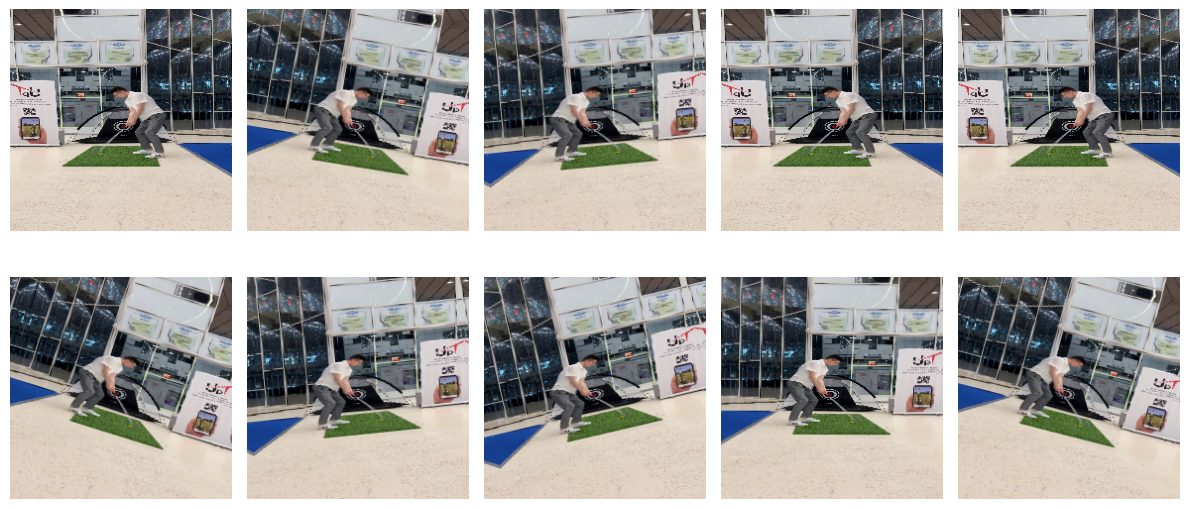

In [8]:
def visualize_augmentations(dataset, idx=8, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

visualize_augmentations(training_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


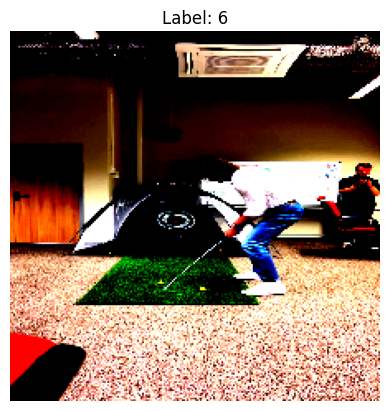

In [9]:
random_index = random.randint(0, len(training_data) - 1)

image, label = training_data[random_index]

image = image.permute(1, 2, 0)

plt.imshow(image)
plt.title("Label: {}".format(label))
plt.axis('off')
plt.show()

In [10]:
# resnet = models.resnet50(pretrained=True)
# for param in resnet.parameters():
#     param.requires_grad = False
# resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(resnet.parameters(), lr=0.01)

In [11]:
# resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
def early_stopping(val_loss):
    global best_loss, early_stopping_counter
    if val_loss < best_loss:
        best_loss = val_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            return True
    return False
def save_checkpoint(model, optimizer, epoch, val_loss, model_name):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': val_loss
    }
    torch.save(checkpoint, f'best_{model_name}.pth')

In [15]:
# best_accuracy = 0
# best_loss = float('inf')
# early_stopping_counter = 0
# patience = 4

# for epoch in range(num_epochs):
#     running_loss = 0.0
    
#     progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
#     for images, labels in progress_bar:
#         # images, labels = images.to(device), labels.to(device)
#         # resnet = resnet.to(device)

#         optimizer.zero_grad()
        
#         images = images.to(device)  # Исправленная строка
#         labels = labels.to(device).long()  # Исправленная строка
#         resnet = resnet.to(device)
#         outputs = resnet(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

#     epoch_loss = running_loss / len(train_dataloader)
#     epoch_loss = round(epoch_loss, 3)
#     print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
#     with torch.no_grad():
#         val_loss = 0.0
#         correct = 0
#         total = 0
        
#         for images, labels in test_dataloader:
#             images = images.to(device)
#             labels = labels.to(device).long()
#             outputs = resnet(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             random_index = random.randint(0, images.size(0) - 1)
#             prediction = predicted[random_index].item()
#             label = labels[random_index].item()

#         val_loss /= len(test_dataloader)
#         val_loss = round(val_loss, 3)
#         accuracy = correct / total

#         print(f"Validation Loss: {val_loss}")
#         print(f"Validation Accuracy: {accuracy}")

#         if accuracy > best_accuracy:
#             best_accuracy = accuracy
#             save_checkpoint(resnet, optimizer, epoch, val_loss, 'tl_resnet50')
        
#         if early_stopping(val_loss):
#             print("Early Stopping!")
#             break

KeyboardInterrupt: 

In [34]:
# checkpoint = torch.load('/kaggle/working/best_tl_resnet50.pth')
# resnet.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# with torch.no_grad():
#     correct = 0
#     total = 0

#     for images, labels in test_dataloader:
#         images = images.to(device)  
#         labels = labels.to(device)  
#         resnet = resnet.to(device)
#         outputs = resnet(images)
#         _, predicted = torch.max(outputs.data, 1)

#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#         random_index = random.randint(0, images.size(0) - 1)
#         prediction = predicted[random_index].item()
#         label = labels[random_index].item()

#     accuracy = correct / total
#     print(f"Test Accuracy: {accuracy}")
#     print(f"{correct}/{total}")

Test Accuracy: 0.839
839/1000


In [35]:
# optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
# layersTofreeze = ['layer1', 'layer2', 'layer3', 'layer4']
# for i in reversed(layersTofreeze):
#     for j in reversed(resnet.get_submodule(i)):
#         j.requires_grad_(True)
#         progress_bar = tqdm(train_dataloader, desc=f"", leave=False)
    
#     for images, labels in progress_bar:
#         # images, labels = images.to(device), labels.to(device)
#         # resnet = resnet.to(device)

#         optimizer.zero_grad()
        
#         images = images.to(device)  # Исправленная строка
#         labels = labels.to(device)  # Исправленная строка
#         resnet = resnet.to(device)
#         outputs = resnet(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

#     epoch_loss = running_loss / len(train_dataloader)
#     epoch_loss = round(epoch_loss, 3)
#     print(f"Loss: {epoch_loss}")
    
#     with torch.no_grad():
#         val_loss = 0.0
#         correct = 0
#         total = 0
        
#         for images, labels in test_dataloader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = resnet(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#             random_index = random.randint(0, images.size(0) - 1)
#             prediction = predicted[random_index].item()
#             label = labels[random_index].item()

#         val_loss /= len(test_dataloader)
#         val_loss = round(val_loss, 3)
#         accuracy = correct / total

#         print(f"Validation Loss: {val_loss}")
#         print(f"Validation Accuracy: {accuracy}")


  0%|          | 0/125 [00:00<?, ?it/s]


Loss: 0.921
Validation Loss: 0.267
Validation Accuracy: 0.914


  0%|          | 0/125 [00:00<?, ?it/s]
                                       
  0%|          | 0/125 [00:00<?, ?it/s]
                                       
                                       
100%|██████████| 125/125 [00:50<00:00,  2.36it/s, Loss=1.1]
                                                           

Loss: 1.098
Validation Loss: 0.277
Validation Accuracy: 0.912


  0%|          | 0/125 [00:00<?, ?it/s]
                                       
                                       
100%|██████████| 125/125 [00:57<00:00,  2.32it/s, Loss=1.2]
                                                           

Loss: 1.204
Validation Loss: 0.293
Validation Accuracy: 0.928


  0%|          | 0/125 [00:00<?, ?it/s]


Loss: 1.331
Validation Loss: 0.225
Validation Accuracy: 0.927


In [10]:
resnet = models.resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.01)

In [16]:
best_accuracy = 0
best_loss = float('inf')
early_stopping_counter = 0
patience = 4

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()  # Исправленная строка
        resnet = resnet.to(device)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(resnet, optimizer, epoch, val_loss, 'tl_resnet18_2')
        
        if early_stopping(val_loss):
            print("Early Stopping!")
            break

Epoch 1 Loss: 1.993
Validation Loss: 2.602
Validation Accuracy: 0.21296296296296297


Epoch 2 Loss: 1.932
Validation Loss: 2.066
Validation Accuracy: 0.3148148148148148


Epoch 3 Loss: 1.727
Validation Loss: 1.941
Validation Accuracy: 0.2962962962962963


Epoch 4 Loss: 1.567
Validation Loss: 2.043
Validation Accuracy: 0.2777777777777778


Epoch 5 Loss: 1.505
Validation Loss: 2.136
Validation Accuracy: 0.32407407407407407


Epoch 6 Loss: 1.794
Validation Loss: 1.975
Validation Accuracy: 0.32407407407407407


Epoch 7 Loss: 1.618
Validation Loss: 2.046
Validation Accuracy: 0.2962962962962963
Early Stopping!


In [18]:
checkpoint = torch.load('best_tl_resnet18_2.pth')
resnet.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_dataloader:
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device)  # Исправленная строка
        resnet = resnet.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        random_index = random.randint(0, images.size(0) - 1)
        prediction = predicted[random_index].item()
        label = labels[random_index].item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")
    print(f"{correct}/{total}")

Test Accuracy: 0.3148148148148148
34/108


In [19]:
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
layersTofreeze = ['layer1', 'layer2', 'layer3', 'layer4']
for i in reversed(layersTofreeze):
    for j in reversed(resnet.get_submodule(i)):
        j.requires_grad_(True)
        progress_bar = tqdm(train_dataloader, desc=f"", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()  # Исправленная строка
        resnet = resnet.to(device)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")


Loss: 3.176
Validation Loss: 1.769
Validation Accuracy: 0.3611111111111111


Loss: 4.147
Validation Loss: 1.313
Validation Accuracy: 0.48148148148148145


Loss: 4.803
Validation Loss: 1.177
Validation Accuracy: 0.5370370370370371


Loss: 5.285
Validation Loss: 1.11
Validation Accuracy: 0.6574074074074074


In [20]:
for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for images, labels in progress_bar:
        # images, labels = images.to(device), labels.to(device)
        # resnet = resnet.to(device)

        optimizer.zero_grad()
        
        images = images.to(device)  # Исправленная строка
        labels = labels.to(device).long()  # Исправленная строка
        resnet = resnet.to(device)
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix({"Loss": running_loss / (len(progress_bar) + 1e-6)})

    epoch_loss = running_loss / len(train_dataloader)
    epoch_loss = round(epoch_loss, 3)
    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    
    with torch.no_grad():
        val_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device).long()
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            random_index = random.randint(0, images.size(0) - 1)
            prediction = predicted[random_index].item()
            label = labels[random_index].item()

        val_loss /= len(test_dataloader)
        val_loss = round(val_loss, 3)
        accuracy = correct / total

        print(f"Validation Loss: {val_loss}")
        print(f"Validation Accuracy: {accuracy}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(resnet, optimizer, epoch, val_loss, 'tl_resnet18.pt')
        
        if early_stopping(val_loss):
            print("Early Stopping!")
            break

Epoch 1 Loss: 0.419
Validation Loss: 1.008
Validation Accuracy: 0.6111111111111112


Epoch 2 Loss: 0.336
Validation Loss: 1.061
Validation Accuracy: 0.6574074074074074


Epoch 3 Loss: 0.292
Validation Loss: 0.9
Validation Accuracy: 0.6851851851851852


Epoch 4 Loss: 0.277
Validation Loss: 0.805
Validation Accuracy: 0.7037037037037037


Epoch 5 Loss: 0.2
Validation Loss: 0.883
Validation Accuracy: 0.7129629629629629


Epoch 6 Loss: 0.17
Validation Loss: 0.839
Validation Accuracy: 0.7407407407407407


Epoch 7 Loss: 0.202
Validation Loss: 0.771
Validation Accuracy: 0.75


Epoch 8 Loss: 0.173
Validation Loss: 0.841
Validation Accuracy: 0.7037037037037037


Epoch 9 Loss: 0.138
Validation Loss: 0.793
Validation Accuracy: 0.6759259259259259


Epoch 10 Loss: 0.132
Validation Loss: 0.943
Validation Accuracy: 0.6944444444444444


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Test Accuracy: 0.7037037037037037
76/108


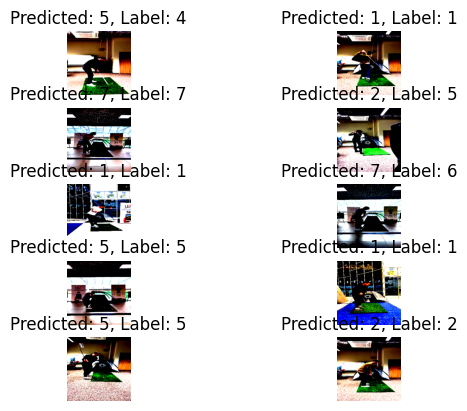

In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    labels_list = []
    predicted_list = []

    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        resnet = resnet.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(images.size(0)):
            labels_list.append(labels[i].item())
            predicted_list.append(predicted[i].item())
            
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy}")
    print(f"{correct}/{total}")
    
# Выводим информацию для каждого изображения
    for i in range(10):
        plt.subplot(5, 2, i+1)
        plt.imshow(images[i].cpu().permute(1, 2, 0))
        plt.title(f"Predicted: {predicted_list[i]}, Label: {labels_list[i]}")
        plt.axis('off')

    plt.show()

In [60]:
import cv2

# Создание и загрузка модели
resnet = models.resnet18(pretrained=True)
num_classes = 8
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
model_path = 'best_tl_resnet18.pt.pth'
checkpoint = torch.load(model_path)
resnet.load_state_dict(checkpoint['model_state_dict'])
resnet = resnet.to(device)
resnet.eval()

# Соответствие между метками и их названиями
label_mapping = {
    0: "P1",
    1: "P10",
    2: "P2",
    3: "P3",
    4: "P4",
    5: "P5",
    6: "P7",
    7: "P8"
}

# Загрузка видео
video_path = 'Test2/vid.mp4'
cap = cv2.VideoCapture(video_path)

#######################################условие
previous_label = None
predictions = []
replace_labels = {"P7": "P2", "P8": "P3", "P2": "P7", "P3": "P8"}
expected_labels = ["P1", "P2", "P3", "P4", "P5", "P7", "P8"]
########################################условие

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width, frame_height))
predictions = []

# Проход по кадрам видео
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Преобразования, аналогичные тем, что использовались при обучении модели
    transform = A.Compose([
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

    transformed_frame = transform(image=frame)['image']
    transformed_frame = transformed_frame.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = resnet(transformed_frame)
        _, predicted = torch.max(outputs.data, 1)
        predicted_label = label_mapping[predicted.item()]  # Получаем соответствующую метку


        
        if "P4" not in predictions:
            if predicted_label == "P7":
                predicted_label = "P2"
            elif predicted_label == "P8":
                predicted_label = "P1"
            elif predicted_label == "P5":
                predicted_label = "P4"
            predictions.append(predicted_label)
        elif "P10" not in predictions:
            if predicted_label == "P3":
                predicted_label = "P5"
            elif predicted_label == "P2":
                predicted_label = "P7"
            elif predicted_label == "P1":
                predicted_label = "P8"
            predictions.append(predicted_label)
        
        # elif "P5" in predictions and predicted_label == "P2":
        #     predicted_label = "P8"
        #     predictions.append(predicted_label)
        # elif "P5" in predictions and predicted_label == "P3":
        #     predicted_label = "P7"
        #     predictions.append(predicted_label)
        # else:
        #     predictions.append(predicted_label)

        previous_label = predicted_label

    # Визуализация предсказанной метки на кадре
    label_name = predicted_label
    cv2.putText(frame, f'Predicted: {label_name}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    predictions.append(predicted_label)  # Добавляем предсказанную метку в список

    out.write(frame)

# Закрытие видеофайла
cap.release()
out.release()
cv2.destroyAllWindows()

for i in range(len(predictions)):
    print(i, " ",predictions[i])
    


0   P1
1   P1
2   P1
3   P1
4   P1
5   P1
6   P1
7   P1
8   P1
9   P1
10   P1
11   P1
12   P1
13   P1
14   P1
15   P1
16   P1
17   P1
18   P1
19   P1
20   P1
21   P1
22   P2
23   P2
24   P1
25   P1
26   P1
27   P1
28   P2
29   P2
30   P2
31   P2
32   P2
33   P2
34   P1
35   P1
36   P2
37   P2
38   P2
39   P2
40   P3
41   P3
42   P3
43   P3
44   P3
45   P3
46   P3
47   P3
48   P3
49   P3
50   P4
51   P4
52   P5
53   P5
54   P4
55   P4
56   P4
57   P4
58   P4
59   P4
60   P4
61   P4
62   P4
63   P4
64   P4
65   P4
66   P4
67   P4
68   P4
69   P4
70   P4
71   P4
72   P4
73   P4
74   P4
75   P4
76   P4
77   P4
78   P5
79   P5
80   P5
81   P5
82   P5
83   P5
84   P8
85   P8
86   P8
87   P8
88   P7
89   P7
90   P7
91   P7
92   P8
93   P8
94   P8
95   P8
96   P8
97   P8
98   P8
99   P8
100   P8
101   P8
102   P8
103   P8
104   P8
105   P8
106   P8
107   P8
108   P10
109   P10
110   P10
111   P10
112   P10
113   P10
114   P10
115   P10
116   P10
117   P10
118   P10
119   P10
120   P10
121   P1

In [55]:
import os
import cv2
import pandas as pd

# Создание и загрузка модели
resnet = models.resnet18(pretrained=True)
num_classes = 8
resnet.fc = torch.nn.Linear(resnet.fc.in_features, num_classes)
model_path = 'best_tl_resnet18.pt.pth'
checkpoint = torch.load(model_path)
resnet.load_state_dict(checkpoint['model_state_dict'])
resnet = resnet.to(device)
resnet.eval()

# Соответствие между метками и их названиями
label_mapping = {
    0: "P1",
    1: "P10",
    2: "P2",
    3: "P3",
    4: "P4",
    5: "P5",
    6: "P7",
    7: "P8"
}

# Загрузка видео
# video_path = 'firstvid.mp4'
cap = cv2.VideoCapture(video_path)


test_folder = 'Test2'
video_files = [f for f in os.listdir(test_folder) if f.endswith('.mp4')]

results = []

# Создайте список всех возможных позиций
positions = ["P1", "P2", "P3", "P4", "P5", "P7", "P8", "P10"]

for video_file in video_files:
    video_path = os.path.join(test_folder, video_file)
    cap = cv2.VideoCapture(video_path)
    frame_numbers = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])
        transformed_frame = transform(image=frame)['image']
        transformed_frame = transformed_frame.unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = resnet(transformed_frame)
            _, predicted = torch.max(outputs.data, 1)
            predicted_label = label_mapping[predicted.item()]

        if predicted_label in positions:
            frame_numbers[predicted_label] = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

    cap.release()

    video_result = {'VideoName': video_file}
    for position in positions:
        if position in frame_numbers:
            video_result[position] = frame_numbers[position]
        else:
            video_result[position] = '-'

    results.append(video_result)

df = pd.DataFrame(results)
df.to_csv('results2.csv', index=False)

In [48]:
import torch
from torchvision.models import resnet

# Pytorch environment
modelpth = 'body_pose_model.pth'
mobile_pt = 'model_body.pt'  # save the model as a file that Android can call

# Load the model's state dictionary from the checkpoint
checkpoint = torch.load(modelpth)
model_state_dict = checkpoint['conv3_3.bias']

# Create the model architecture
model = opencv()  # Replace with the actual class of your model
model.load_state_dict(model_state_dict)
model.eval()  # Set the model to evaluation mode

device = torch.device('cpu')
model.to(device)

# Create an example input tensor
input_tensor = torch.rand(1, 3, 224, 224)  # 1 picture of 3-channel 224*224

# Script the model
scripted_model = torch.jit.script(model)

# Save the scripted model
scripted_model.save(mobile_pt)

NameError: name 'opencv' is not defined

In [29]:
# import torch.onnx as onnx

# model = resnet
# dummy_input = torch.randn(1, 3, 224, 224)
# onnx.export(model, dummy_input, "model.onnx")

============== Diagnostic Run torch.onnx.export version 2.0.1+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

